In [1]:
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from scipy.linalg import toeplitz, circulant
from matplotlib import pyplot as plt
import config
import models
import tasks
import networks
import plots
import argparse
import json
import time
import torch
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import math
import os
import numpy as np
import pathlib
from sklearn.manifold import TSNE

In [165]:
noise_amplitude = 0.1 #*0
dim_recurrent = 100
simple_input = False
simple_output = True
hold_zero=False
redo_preanalysis = True # None = redo only if necessary

ORI_RES = 3

hold_orientation_for = 10
hold_cue_for = 100
delay0_set = torch.tensor([0]) 
delay0_set = torch.arange(30, 50)
delay1_set = torch.arange(30, 50)
delay2_set = torch.arange(30, 50)
delay0, delay1, delay2 = 40, 40, 40

total_time = hold_orientation_for*2+hold_cue_for+delay0+delay1+delay2

orientation_neurons = 32
task = tasks.TWO_ORIENTATIONS_DOUBLE_OUTPUT(orientation_neurons, hold_orientation_for, hold_cue_for, delay0_set, delay1_set, delay2_set,
                                        simple_input=simple_input, simple_output=simple_output)
model = models.CTRNN(task=task, dim_recurrent=dim_recurrent, nonlinearity="retanh")

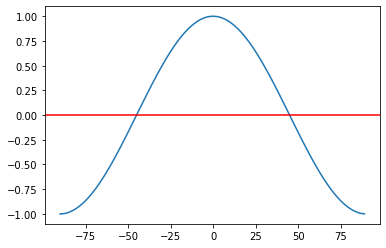

In [124]:
def weight(pref1, pref2):
    return 1 * ( torch.cos(2*(pref1-pref2)/180 * np.pi))
    a = 0.5
    return np.maximum(np.minimum(1+a-torch.abs(pref1-pref2)/90 * 2*(1+a), 1.), -1.)
N = torch.arange(-90, 90, 1)
plt.plot(N, weight(N, 0))
plt.axhline(y = 0, color = 'r', linestyle = '-')

## R1 stronger than R2

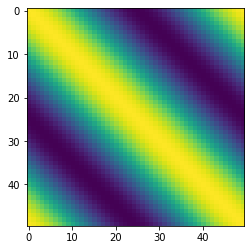

In [166]:
R1_N = 50
R1_pref = torch.arange(R1_N) * 180 / R1_N
R1_W = torch.zeros(R1_N, R1_N)
for i in range(R1_N):
    for j in range(R1_N):
        R1_W[i, j] = weight(R1_pref[i], R1_pref[j])
R2_N = 50
R2_pref = torch.arange(R2_N) * 180 / R2_N
R2_W = torch.zeros(R2_N, R2_N)
for i in range(R2_N):
    for j in range(R2_N):
        R2_W[i, j] = weight(R2_pref[i], R2_pref[j])
IN_N = 32
IN_pref = torch.arange(IN_N) * 180 / IN_N
IN_R1_W = torch.zeros(R1_N, IN_N)
for i in range(R1_N):
    for j in range(IN_N):
        IN_R1_W[i, j] = weight(R1_pref[i], IN_pref[j])
plt.imshow(R1_W)

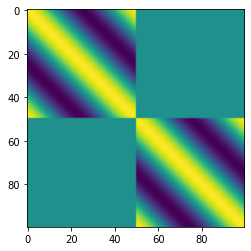

In [167]:
with torch.no_grad():
    model.fc_x2ah.weight[:, :] = 0
    model.fc_x2ah.bias[:] = 0
    model.fc_h2ah.weight[:, :] = 0
    model.fc_h2y.weight[:, :] = 0
    model.fc_h2y.bias[:] = 0
    
    model.fc_x2ah.weight[:50, :-1] = IN_R1_W * 0.2
    model.fc_x2ah.weight[50:, :-1] = IN_R1_W * 2.0
    model.fc_x2ah.bias[:] = -.2
    model.fc_h2ah.weight[:50, :50] = R1_W * 0.2
    model.fc_h2ah.weight[50:, 50:] = R2_W * 0.2
plt.imshow(model.fc_h2ah.weight.detach().numpy())

In [128]:
torch.save({'model_state_dict': model.state_dict()}, "data/model_hd.pth")

## Gate blocks info to R1

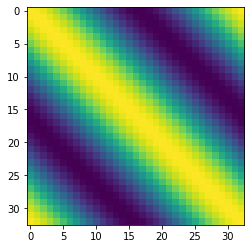

In [168]:
R1_N = 33
R1_pref = torch.arange(R1_N) * 180 / R1_N
R1_W = torch.zeros(R1_N, R1_N)
for i in range(R1_N):
    for j in range(R1_N):
        R1_W[i, j] = weight(R1_pref[i], R1_pref[j])
R2_N = 34
R2_pref = torch.arange(R2_N) * 180 / R2_N
R2_W = torch.zeros(R2_N, R2_N)
for i in range(R2_N):
    for j in range(R2_N):
        R2_W[i, j] = weight(R2_pref[i], R2_pref[j])
IN_N = 32
IN_pref = torch.arange(IN_N) * 180 / IN_N
IN_R1_W = torch.zeros(R1_N, IN_N)
for i in range(R1_N):
    for j in range(IN_N):
        IN_R1_W[i, j] = weight(R1_pref[i], IN_pref[j])
IN_R2_W = torch.zeros(R2_N, IN_N)
for i in range(R2_N):
    for j in range(IN_N):
        IN_R2_W[i, j] = weight(R2_pref[i], IN_pref[j])
DT_N = 33
DT_pref = torch.arange(DT_N) * 180 / DT_N
IN_DT_W = torch.zeros(DT_N, IN_N)
for i in range(DT_N):
    for j in range(IN_N):
        IN_DT_W[i, j] = weight(DT_pref[i], IN_pref[j])
DT_R1_W = torch.zeros(R1_N, DT_N)
for i in range(R1_N):
    for j in range(DT_N):
        DT_R1_W[i, j] = weight(R1_pref[i], DT_pref[j])
R1_i = torch.arange(0, R1_N, dtype=int)
DT_i = torch.arange(R1_N, R1_N+DT_N, dtype=int)
R2_i = torch.arange(R1_N+DT_N, R1_N+DT_N+R2_N, dtype=int)
plt.imshow(R1_W)

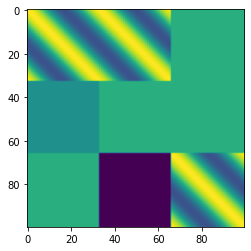

In [220]:
model = models.CTRNN(task=task, dim_recurrent=dim_recurrent, nonlinearity="retanh")
with torch.no_grad():
    model.fc_x2ah.weight[:, :] = 0
    model.fc_x2ah.bias[:] = 0
    model.fc_h2ah.weight[:, :] = 0
    model.fc_h2y.weight[:, :] = 0
    model.fc_h2y.bias[:] = 0
    
    model.fc_x2ah.weight[R2_i, :-1] = IN_R2_W * 0.3
    model.fc_x2ah.weight[DT_i, :-1] = IN_DT_W * 0.3
    model.fc_x2ah.weight[R1_i, :-1] = IN_R1_W * 0.0
    model.fc_x2ah.bias[:] = -.2
    model.fc_h2ah.weight[min(R1_i):max(R1_i)+1, :][:, min(R1_i):max(R1_i)+1] = R1_W * 0.3
    model.fc_h2ah.weight[min(R2_i):max(R2_i)+1, :][:, min(R2_i):max(R2_i)+1] = R2_W * 0.3
    model.fc_h2ah.weight[min(R1_i):max(R1_i)+1, :][:, min(DT_i):max(DT_i)+1] = DT_R1_W * 0.3
    model.fc_h2ah.weight[min(DT_i):max(DT_i)+1, :][:, min(R1_i):max(R1_i)+1] = (-1) * .1
    model.fc_h2ah.weight[min(R2_i):max(R2_i)+1, :][:, min(DT_i):max(DT_i)+1] = (-1) * .5
    
    model.fc_h2y.weight[1, R1_i] = torch.cos(2 * R1_pref / 180 * np.pi) * 0.1
    model.fc_h2y.weight[0, R1_i] = torch.sin(2 * R1_pref / 180 * np.pi) * 0.1
    model.fc_h2y.weight[3, R2_i] = torch.cos(2 * R2_pref / 180 * np.pi) * 0.1
    model.fc_h2y.weight[2, R2_i] = torch.sin(2 * R2_pref / 180 * np.pi) * 0.1
plt.imshow(model.fc_h2ah.weight.detach().numpy())

In [221]:
model.fc_h2y.weight.shape

torch.Size([4, 100])

In [222]:
torch.save({'model_state_dict': model.state_dict()}, "data/model_hd.pth")

## R2 flips DT

In [ ]:
R1_N = 33
R1_pref = torch.arange(R1_N) * 180 / R1_N
R1_W = torch.zeros(R1_N, R1_N)
for i in range(R1_N):
    for j in range(R1_N):
        R1_W[i, j] = weight(R1_pref[i], R1_pref[j])
R2_N = 34
R2_pref = torch.arange(R2_N) * 180 / R2_N
R2_W = torch.zeros(R2_N, R2_N)
for i in range(R2_N):
    for j in range(R2_N):
        R2_W[i, j] = weight(R2_pref[i], R2_pref[j])
IN_N = 32
IN_pref = torch.arange(IN_N) * 180 / IN_N
IN_R1_W = torch.zeros(R1_N, IN_N)
for i in range(R1_N):
    for j in range(IN_N):
        IN_R1_W[i, j] = weight(R1_pref[i], IN_pref[j])
IN_R2_W = torch.zeros(R2_N, IN_N)
for i in range(R2_N):
    for j in range(IN_N):
        IN_R2_W[i, j] = weight(R2_pref[i], IN_pref[j])
DT_N = 33
DT_pref = torch.arange(DT_N) * 180 / DT_N
IN_DT_W = torch.zeros(DT_N, IN_N)
for i in range(DT_N):
    for j in range(IN_N):
        IN_DT_W[i, j] = weight(DT_pref[i], IN_pref[j])
DT_R1_W = torch.zeros(R1_N, DT_N)
for i in range(R1_N):
    for j in range(DT_N):
        DT_R1_W[i, j] = weight(R1_pref[i], DT_pref[j])
R1_i = torch.arange(0, R1_N, dtype=int)
DT_i = torch.arange(R1_N, R1_N+DT_N, dtype=int)
R2_i = torch.arange(R1_N+DT_N, R1_N+DT_N+R2_N, dtype=int)
plt.imshow(R1_W)